# For-2 Seconds Dataset

1) Importing the important libraries.

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from imblearn.over_sampling import SMOTE  # For oversampling
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')


2) Loading the dataset.

In [3]:
def load_audio_data(folder, target_duration=2.0, sample_rate=22050):
    audio_data = []
    labels = []
    
    target_length = int(sample_rate * target_duration)  # 2 seconds at 22050 Hz = 44100 samples
    
    for label in ['real', 'fake']:
        subfolder = os.path.join(folder, label)
        for file_name in os.listdir(subfolder):
            file_path = os.path.join(subfolder, file_name)
            audio, sr = librosa.load(file_path, sr=sample_rate, mono=True, dtype=np.float32)
            
            # Ensure the audio is exactly 2 seconds long
            if len(audio) < target_length:
                audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
            elif len(audio) > target_length:
                audio = audio[:target_length]
            
            audio_data.append(audio)
            labels.append(label)
    
    # Convert to a 2D NumPy array with shape (n_samples, target_length)
    audio_data = np.array(audio_data, dtype=np.float32)
    return audio_data, np.array(labels)

# Load the training data
train_audio, train_labels = load_audio_data(r'for-2seconds\training')
print("Loaded audio data shape:", train_audio.shape)

Loaded audio data shape: (17720, 44100)


3) Data visulization of real and fake audio.Visualizing Spectrogram and Decibels (dB).

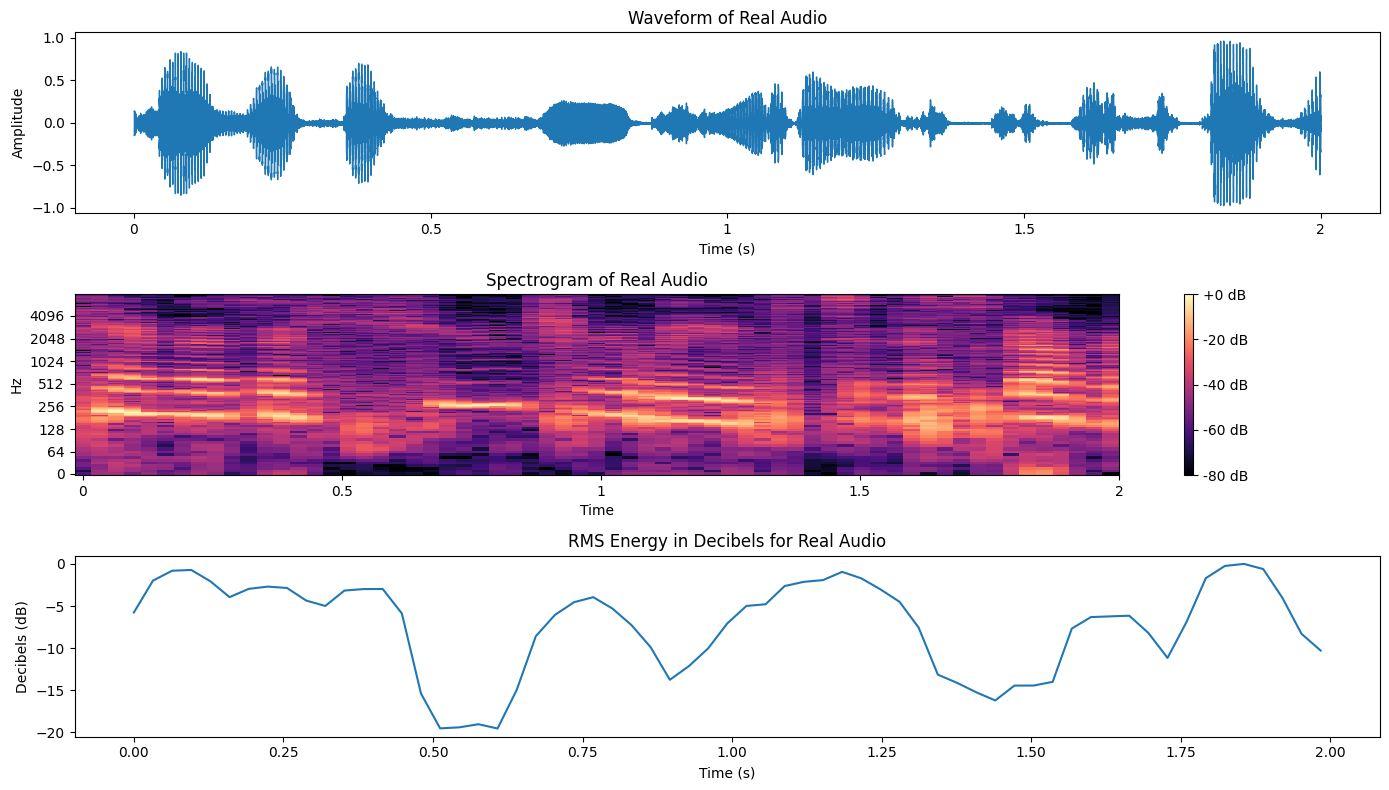

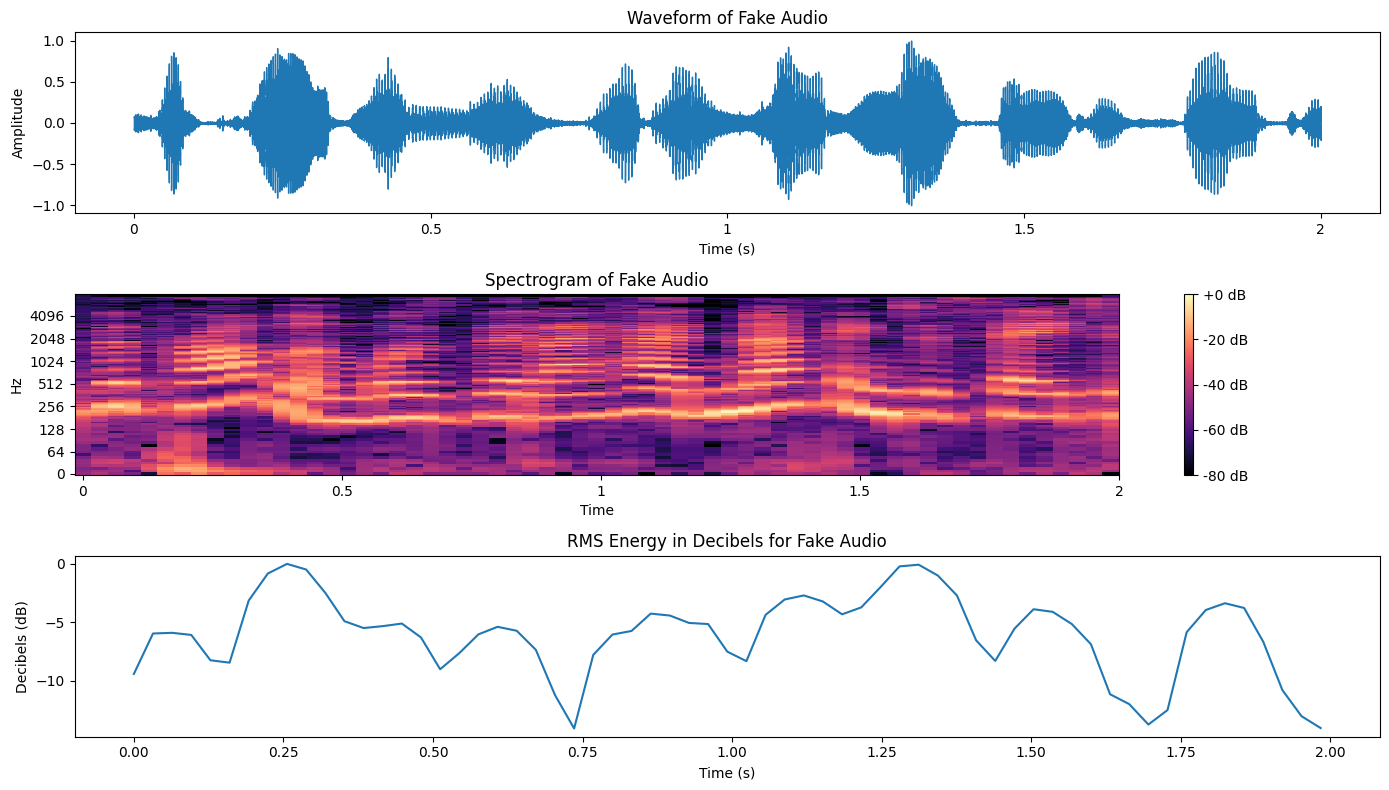

In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the real and fake audio files
real_audio_path = 'for-2seconds/training/real/file2.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav'
fake_audio_path = 'for-2seconds/training/fake/file6.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav'

# Load the real audio file
real_audio, sr_real = librosa.load(real_audio_path, sr=None)

# Load the fake audio file
fake_audio, sr_fake = librosa.load(fake_audio_path, sr=None)

# Function to plot the spectrogram and decibel for an audio signal
def plot_audio_visualizations(audio_signal, sample_rate, title):
    plt.figure(figsize=(14, 8))

    # Plot waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(audio_signal, sr=sample_rate)
    plt.title(f'Waveform of {title}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot Spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_signal)), ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of {title}')

    # Plot decibel (dB) over time
    plt.subplot(3, 1, 3)
    rms = librosa.feature.rms(y=audio_signal)[0]
    times = librosa.times_like(rms, sr=sample_rate)
    plt.plot(times, librosa.amplitude_to_db(rms, ref=np.max), label='RMS Energy (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Decibels (dB)')
    plt.title(f'RMS Energy in Decibels for {title}')

    plt.tight_layout()
    plt.show()

# Visualize Real Audio
plot_audio_visualizations(real_audio, sr_real, 'Real Audio')

# Visualize Fake Audio
plot_audio_visualizations(fake_audio, sr_fake, 'Fake Audio')


4) Extracting mfcc features from the respective audio sets.

In [5]:
def extract_mfcc_features(audio_data, sample_rate, n_mfcc=40):
    # Ensure audio_data is a 2D array of shape (n_samples, n_timesteps)
    if audio_data.dtype != np.float32:
        audio_data = audio_data.astype(np.float32)
    
    mfccs = [librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc).mean(axis=1) for audio in audio_data]
    return np.array(mfccs)


5) Extracting spectral features from the respective audio sets.

In [6]:
def extract_spectral_features(audio_data, sample_rate):
    if audio_data.dtype != np.float32:
        audio_data = audio_data.astype(np.float32)
    
    spectral_features = []
    for audio in audio_data:
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate).mean()
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate).mean()
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate).mean(axis=1)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate).mean()
        combined_spectral = np.hstack([spectral_centroid, spectral_rolloff, spectral_contrast, spectral_bandwidth])
        spectral_features.append(combined_spectral)
    return np.array(spectral_features)

6) Extracting raw signal features from the respective audio sets.

In [7]:
def extract_raw_signal_features(audio_data, sample_rate):
    if audio_data.dtype != np.float32:
        audio_data = audio_data.astype(np.float32)
    
    raw_features = []
    for audio in audio_data:
        zero_cross_rate = librosa.feature.zero_crossing_rate(y=audio).mean()
        signal_energy = np.sum(audio**2) / len(audio)
        raw_features.append([zero_cross_rate, signal_energy])
    return np.array(raw_features)

7) Ensembling all the three features.

In [8]:
def combine_features(mfcc, spectral, raw):
    combined_features = np.hstack((mfcc, spectral, raw))
    return combined_features

# Extract features
train_mfcc = extract_mfcc_features(train_audio, 22050)
train_spectral = extract_spectral_features(train_audio, 22050)
train_raw = extract_raw_signal_features(train_audio, 22050)
train_features = combine_features(train_mfcc, train_spectral, train_raw)

print("Training features shape:", train_features.shape)


Training features shape: (17720, 52)


8) Convert labels from categorical (real, fake) to numerical values.

In [9]:
encoder = LabelEncoder()
train_labels_encoded = encoder.fit_transform(train_labels)  # "fake" → 0, "real" → 1
print("Label encoding:", dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))



Label encoding: {'fake': 0, 'real': 1}


9) Check for class imbalance and apply oversampling if needed

In [10]:
unique, counts = np.unique(train_labels, return_counts=True)
print("Class distribution before oversampling:", dict(zip(unique, counts)))

# Apply SMOTE if there's significant imbalance
smote = SMOTE(random_state=42)
train_features, train_labels_encoded = smote.fit_resample(train_features, train_labels_encoded)

unique, counts = np.unique(train_labels_encoded, return_counts=True)
print("Class distribution after oversampling:", dict(zip(unique, counts)))

Class distribution before oversampling: {'fake': 8920, 'real': 8800}
Class distribution after oversampling: {0: 8920, 1: 8920}


10) Scale the features

In [11]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)

11) spliting the training data into test and train and evaluate using different models.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    train_features_scaled, train_labels_encoded, test_size=0.2, random_state=42
)


12) classification report of 10 different ML models.


Model: MLP
Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│    Class     │  Precision  │  Recall  │  F1-Score  │  Support  │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│     Fake     │    0.998    │    1     │   0.999    │   1794    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Real     │      1      │  0.998   │   0.999    │   1774    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│  macro avg   │    0.999    │  0.999   │   0.999    │   3568    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │    0.999    │  0.999   │   0.999    │   3568    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


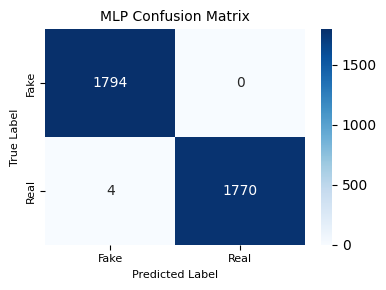


Model: Decision Tree
Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│    Class     │  Precision  │  Recall  │  F1-Score  │  Support  │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│     Fake     │    0.959    │  0.962   │   0.961    │   1794    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Real     │    0.962    │  0.959   │    0.96    │   1774    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│  macro avg   │    0.96     │   0.96   │    0.96    │   3568    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │    0.96     │   0.96   │    0.96    │   3568    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


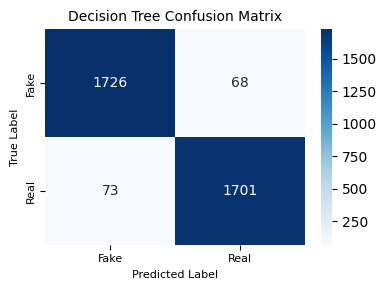


Model: Extra Tree
Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│    Class     │  Precision  │  Recall  │  F1-Score  │  Support  │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│     Fake     │    0.999    │  0.996   │   0.997    │   1794    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Real     │    0.996    │  0.999   │   0.997    │   1774    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│  macro avg   │    0.997    │  0.997   │   0.997    │   3568    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │    0.997    │  0.997   │   0.997    │   3568    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


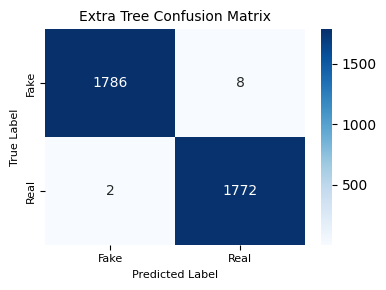


Model: AdaBoost
Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│    Class     │  Precision  │  Recall  │  F1-Score  │  Support  │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│     Fake     │    0.968    │  0.975   │   0.971    │   1794    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Real     │    0.974    │  0.967   │   0.971    │   1774    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│  macro avg   │    0.971    │  0.971   │   0.971    │   3568    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │    0.971    │  0.971   │   0.971    │   3568    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


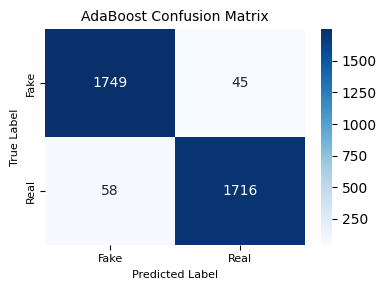


Model: Gradient Boosting
Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│    Class     │  Precision  │  Recall  │  F1-Score  │  Support  │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│     Fake     │    0.988    │  0.984   │   0.986    │   1794    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Real     │    0.984    │  0.988   │   0.986    │   1774    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│  macro avg   │    0.986    │  0.986   │   0.986    │   3568    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │    0.986    │  0.986   │   0.986    │   3568    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


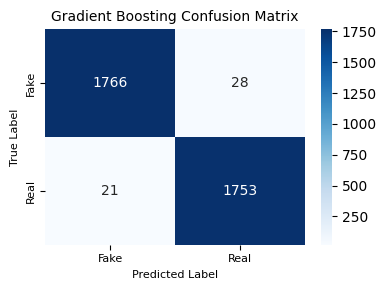


Model: XGBoost
Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│    Class     │  Precision  │  Recall  │  F1-Score  │  Support  │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│     Fake     │    0.998    │  0.997   │   0.997    │   1794    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Real     │    0.997    │  0.998   │   0.997    │   1774    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│  macro avg   │    0.997    │  0.997   │   0.997    │   3568    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │    0.997    │  0.997   │   0.997    │   3568    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


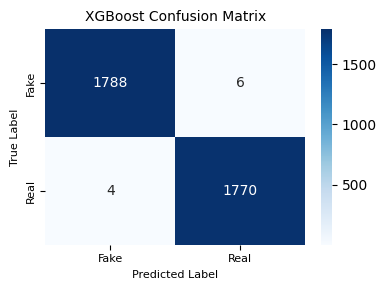


Model: QDA
Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│    Class     │  Precision  │  Recall  │  F1-Score  │  Support  │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│     Fake     │    0.999    │  0.983   │   0.991    │   1794    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Real     │    0.983    │  0.999   │   0.991    │   1774    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│  macro avg   │    0.991    │  0.991   │   0.991    │   3568    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │    0.991    │  0.991   │   0.991    │   3568    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


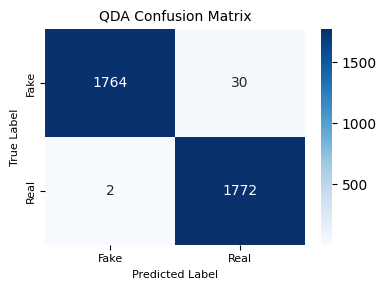


Combined Classification Report for All Models
╒═══════════════════╤════════════╤════════════════════╤═════════════════╤═══════════════════╤════════════════════╤═════════════════╤═══════════════════╕
│       Model       │  Accuracy  │  Precision (Real)  │  Recall (Real)  │  F1-Score (Real)  │  Precision (Fake)  │  Recall (Fake)  │  F1-Score (Fake)  │
╞═══════════════════╪════════════╪════════════════════╪═════════════════╪═══════════════════╪════════════════════╪═════════════════╪═══════════════════╡
│        MLP        │   99.89%   │         1          │      0.998      │       0.999       │       0.998        │        1        │       0.999       │
├───────────────────┼────────────┼────────────────────┼─────────────────┼───────────────────┼────────────────────┼─────────────────┼───────────────────┤
│   Decision Tree   │   96.05%   │       0.962        │      0.959      │       0.96        │       0.959        │      0.962      │       0.961       │
├───────────────────┼────────────┼─

In [13]:
all_predictions = {}
all_reports = {}

# Modified train_and_evaluate_model function
def train_and_evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Store predictions
    all_predictions[model_name] = y_pred
    
    # Get classification report as a dictionary for tabulate
    report_dict = classification_report(y_test, y_pred, target_names=['Fake', 'Real'], output_dict=True)
    
    # Convert classification report to a table format
    report_data = []
    for label in ['Fake', 'Real']:
        report_data.append([
            label,
            f"{report_dict[label]['precision']:.3f}",
            f"{report_dict[label]['recall']:.3f}",
            f"{report_dict[label]['f1-score']:.3f}",
            int(report_dict[label]['support'])
        ])
    
    # Add macro avg and weighted avg
    report_data.append([
        'macro avg',
        f"{report_dict['macro avg']['precision']:.3f}",
        f"{report_dict['macro avg']['recall']:.3f}",
        f"{report_dict['macro avg']['f1-score']:.3f}",
        int(report_dict['macro avg']['support'])
    ])
    report_data.append([
        'weighted avg',
        f"{report_dict['weighted avg']['precision']:.3f}",
        f"{report_dict['weighted avg']['recall']:.3f}",
        f"{report_dict['weighted avg']['f1-score']:.3f}",
        int(report_dict['weighted avg']['support'])
    ])
    
    # Store report for combined analysis
    all_reports[model_name] = report_dict
    
    # Print individual model results
    print(f"\nModel: {model_name}")
    print("=====================")
    print("Classification Report:")
    print(tabulate(
        report_data,
        headers=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'],
        tablefmt='fancy_grid',
        stralign='center',
        numalign='center'
    ))
    
    # Get confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix as a small heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'],
                annot_kws={"size": 10})
    plt.title(f"{model_name} Confusion Matrix", fontsize=10)
    plt.xlabel('Predicted Label', fontsize=8)
    plt.ylabel('True Label', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

# Define models
models = {
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Extra Tree": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, random_state=42),
    "QDA": QuadraticDiscriminantAnalysis()
}

# Evaluate all models
for name, model in models.items():
    train_and_evaluate_model(model, name)

# Create combined classification report
print("\nCombined Classification Report for All Models")
print("============================================")

# Initialize list to store combined metrics
combined_metrics = []

# Collect metrics from all models
for model_name, report in all_reports.items():
    accuracy = accuracy_score(y_test, all_predictions[model_name]) * 100
    combined_metrics.append([
        model_name,
        f"{accuracy:.2f}%",
        f"{report['Real']['precision']:.3f}",
        f"{report['Real']['recall']:.3f}",
        f"{report['Real']['f1-score']:.3f}",
        f"{report['Fake']['precision']:.3f}",
        f"{report['Fake']['recall']:.3f}",
        f"{report['Fake']['f1-score']:.3f}"
    ])

# Print the combined report as a neat table
print(tabulate(
    combined_metrics,
    headers=['Model', 'Accuracy', 'Precision (Real)', 'Recall (Real)', 'F1-Score (Real)', 
             'Precision (Fake)', 'Recall (Fake)', 'F1-Score (Fake)'],
    tablefmt='fancy_grid',
    stralign='center',
    numalign='center'
))

# Save combined report to CSV
df_combined = pd.DataFrame(
    combined_metrics,
    columns=['Model', 'Accuracy', 'Precision (Real)', 'Recall (Real)', 'F1-Score (Real)', 
             'Precision (Fake)', 'Recall (Fake)', 'F1-Score (Fake)']
)
df_combined.to_csv('combined_classification_report.csv', index=False)

11) Saving pickel file of Best Model(ExtraTrees)

In [21]:
# In the training code, after evaluating all models
# Save the MLP model and scaler
mlp_model = models["MLP"]
joblib.dump(mlp_model, "For_2sec_MLP_model.joblib")
joblib.dump(scaler, "For_2sec_scaler.joblib")
# Optionally, save the LabelEncoder
joblib.dump(encoder, "For_2sec_label_encoder.joblib")
print("MLP model, scaler, and label encoder saved successfully")

MLP model, scaler, and label encoder saved successfully


12) Testing model

In [1]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import joblib
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load the saved model, scaler, and label encoder
try:
    model = joblib.load("For_2sec_MLP_model.joblib")
    scaler = joblib.load("For_2sec_scaler.joblib")
    # Optionally load the LabelEncoder if saved
    try:
        encoder = joblib.load("For_2sec_label_encoder.joblib")
        print("Label encoder loaded successfully")
    except:
        encoder = LabelEncoder()
        encoder.fit(['fake', 'real'])  # Recreate with same order as training
        print("Label encoder recreated (not saved during training)")
    print("Model and scaler loaded successfully")
except Exception as e:
    print(f"Error loading model or scaler: {e}")
    exit(1)

# Step 2: Define feature extraction functions (same as training)
def extract_mfcc_features(audio_data, sample_rate, n_mfcc=40):
    if audio_data.dtype != np.float32:
        audio_data = audio_data.astype(np.float32)
    
    mfccs = []
    for audio in audio_data:
        try:
            mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc).mean(axis=1)
            mfccs.append(mfcc)
        except Exception as e:
            print(f"Warning: Error extracting MFCC for an audio sample. Error: {e}. Using zeros...")
            mfccs.append(np.zeros(n_mfcc))
    return np.array(mfccs)

def extract_spectral_features(audio_data, sample_rate):
    if audio_data.dtype != np.float32:
        audio_data = audio_data.astype(np.float32)
    
    spectral_features = []
    for audio in audio_data:
        try:
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate).mean()
            spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate).mean()
            spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate).mean(axis=1)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate).mean()
            combined_spectral = np.hstack([spectral_centroid, spectral_rolloff, spectral_contrast, spectral_bandwidth])
            spectral_features.append(combined_spectral)
        except Exception as e:
            print(f"Warning: Error extracting spectral features for an audio sample. Error: {e}. Using zeros...")
            spectral_features.append(np.zeros(10))
    return np.array(spectral_features)

def extract_raw_signal_features(audio_data, sample_rate):
    if audio_data.dtype != np.float32:
        audio_data = audio_data.astype(np.float32)
    
    raw_features = []
    for audio in audio_data:
        try:
            zero_cross_rate = librosa.feature.zero_crossing_rate(y=audio).mean()
            signal_energy = np.sum(audio**2) / len(audio)
            raw_features.append([zero_cross_rate, signal_energy])
        except Exception as e:
            print(f"Warning: Error extracting raw signal features for an audio sample. Error: {e}. Using zeros...")
            raw_features.append(np.zeros(2))
    return np.array(raw_features)

def combine_features(mfcc, spectral, raw):
    combined_features = np.hstack((mfcc, spectral, raw))
    return combined_features

# Step 3: Define preprocessing function for a single audio
def preprocess_audio(audio_path, target_duration=2.0, sample_rate=22050):
    try:
        audio, sr = librosa.load(audio_path, sr=sample_rate, mono=True, dtype=np.float32)
        target_length = int(sample_rate * target_duration)
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        elif len(audio) > target_length:
            audio = audio[:target_length]

        # Ensure audio is float32
        audio = audio.astype(np.float32)

        # Extract features (pass as a single-element list to reuse the same function)
        mfcc_features = extract_mfcc_features(np.array([audio]), sample_rate, n_mfcc=40)[0]
        spectral_features = extract_spectral_features(np.array([audio]), sample_rate)[0]
        raw_features = extract_raw_signal_features(np.array([audio]), sample_rate)[0]
        features = combine_features(mfcc_features, spectral_features, raw_features)
        features = features.reshape(1, -1)

        # Use the loaded scaler to transform the features
        features = scaler.transform(features)

        return features
    except Exception as e:
        raise ValueError(f"Error preprocessing audio {audio_path}: {e}")

# Step 4: Define testing function
def test_audio(audio_path, model):
    features = preprocess_audio(audio_path)
    prediction = model.predict(features)
    probs = model.predict_proba(features)
    class_labels = {0: 'Fake', 1: 'Real'}  # Matches LabelEncoder from training
    predicted_class = class_labels[prediction[0]]
    return predicted_class, probs[0]

# Step 5: Test on multiple audios
audio_paths = [
    r"for-2seconds\training\fake\file18.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav",
    r"for-2seconds\training\real\file18.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav"  # A real audio path
]

print("\nTesting on individual audios using saved MLP Classifier model:")
print("=============================================================")
for audio_path in audio_paths:
    try:
        predicted_class, probs = test_audio(audio_path, model)
        print(f"\nAudio: {audio_path}")
        print(f"Predicted Class: {predicted_class}")
        print(f"Probabilities (Fake, Real): {probs}")
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")

# Step 6: Test on a larger subset for overall accuracy
def test_on_subset(folder, num_samples_per_class=10):
    audio_data = []
    true_labels = []
    audio_paths = []
    
    target_length = int(22050 * 2.0)  # 2 seconds at 22050 Hz
    
    for label in ['real', 'fake']:
        subfolder = os.path.join(folder, label)
        if not os.path.exists(subfolder):
            print(f"Warning: Subfolder {subfolder} does not exist. Skipping...")
            continue
        count = 0
        for file_name in os.listdir(subfolder):
            if count >= num_samples_per_class:
                break
            file_path = os.path.join(subfolder, file_name)
            try:
                audio, sr = librosa.load(file_path, sr=22050, mono=True, dtype=np.float32)
                
                # Ensure the audio is exactly 2 seconds long
                if len(audio) < target_length:
                    audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
                elif len(audio) > target_length:
                    audio = audio[:target_length]
                
                audio_data.append(audio)
                true_labels.append(label)
                audio_paths.append(file_path)
                count += 1
            except Exception as e:
                print(f"Warning: Could not load {file_path}. Error: {e}. Skipping...")
    
    if not audio_data:
        print("No audio files were loaded for subset testing.")
        return
    
    # Convert to a 2D NumPy array
    audio_data = np.array(audio_data, dtype=np.float32)
    
    # Extract features
    subset_mfcc = extract_mfcc_features(audio_data, 22050)
    subset_spectral = extract_spectral_features(audio_data, 22050)
    subset_raw = extract_raw_signal_features(audio_data, 22050)
    subset_features = combine_features(subset_mfcc, subset_spectral, subset_raw)
    subset_features = scaler.transform(subset_features)
    
    # Predict
    predictions = model.predict(subset_features)
    predicted_labels = [encoder.inverse_transform([pred])[0] for pred in predictions]
    
    # Calculate accuracy
    true_labels_encoded = encoder.transform(true_labels)
    accuracy = accuracy_score(true_labels_encoded, predictions)
    
    # Display results
    print("\nTesting on a subset of the dataset using saved MLP Classifier model:")
    print("===================================================================")
    print(f"Accuracy on subset: {accuracy:.3f}")
    print("\nDetailed Results:")
    results = []
    for path, true, pred in zip(audio_paths, true_labels, predicted_labels):
        results.append([path, true, pred])
    print(tabulate(
        results,
        headers=['Audio Path', 'True Label', 'Predicted Label'],
        tablefmt='fancy_grid',
        stralign='left'
    ))

# Test on a subset
test_on_subset(r'for-2seconds\training', num_samples_per_class=10)

Label encoder loaded successfully
Model and scaler loaded successfully

Testing on individual audios using saved MLP Classifier model:

Audio: for-2seconds\training\fake\file18.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Predicted Class: Fake
Probabilities (Fake, Real): [9.99997618e-01 2.38215378e-06]

Audio: for-2seconds\training\real\file18.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Predicted Class: Real
Probabilities (Fake, Real): [4.70101968e-06 9.99995299e-01]

Testing on a subset of the dataset using saved MLP Classifier model:
Accuracy on subset: 1.000

Detailed Results:
╒═════════════════════════════════════════════════════════════════════════════════════════════╤══════════════╤═══════════════════╕
│ Audio Path                                                                                  │ True Label   │ Predicted Label   │
╞═════════════════════════════════════════════════════════════════════════════════════════════╪══════════════╪═══════════════════╡
│ f